In [ ]:
!pip install pertpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.5/118.5 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.7/292.7 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.2/300.2 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.0/224.0 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.4/108.4 kB 4.5 MB/s eta 0:00

In [ ]:
!pip install torchmetrics==0.11.4


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 5.8 MB/s eta 0:00:00
  Attempting uninstall: torchmetrics
    Found existing installation: torchmetrics 1.0.1
    Uninstalling torchmetrics-1.0.1:
      Successfully uninstalled torchmetrics-1.0.1


In [ ]:
import pertpy as pt

INFO:pytorch_lightning.utilities.seed:Global seed set to 0
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.


To use sccoda or tasccoda please install ete3 with pip install ete3

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/Colab_Notebooks/perturbation_metric_test

Mounted at /content/drive
/content/drive/MyDrive/Colab_Notebooks/perturbation_metric_test


In [ ]:
import anndata
import scanpy as sc

import pandas as pd
import numpy as np
import pertpy as pt
import matplotlib.pyplot as plt
import seaborn as sns

train = sc.read("./data/PapalexiSatija2021_eccite_RNA.h5ad")
sc.pp.normalize_total(train, target_sum=1e4)
sc.pp.log1p(train)
sc.pp.highly_variable_genes(train, n_top_genes=100, subset=True, min_mean=.1)
sc.pp.pca(train, use_highly_variable=True)
train.obs['exp1']=train.obs['perturbation']

In [ ]:
control=train[train.obs['perturbation']=='control']

def sample_and_merge_control(train,control):

  sample = control.obs.groupby("perturbation").apply(lambda x: x.sample(frac=1,replace=False))# no random state, shuffle
  name=[]
  # print(sample)
  for _,i in sample.index:
    name.append(i)
  new=control[control.obs_names.isin(name)]

  n=new.shape[0]//5
  # print(new,n)
  sub=[]
  # sub=np.split(new,5,0)
  for i in range(5):#subset0:10,10:20,20:30,30:40,40:50
    sub.append(new[i*n:(i+1)*n,:])
    sub[i].obs['exp1']='control'+ str(i+1) #label the subset
    sub[i].obs['perturbation']='control'+ str(i+1)#set up perturbation for ctrl sample
    # new=new[:(i+1)*n+1,:]# ???

  # print(sub)

  merge=train.copy()

  for data in sub:#merge subset with original data
    merge=anndata.concat([merge,data], join="outer")
    # print(merge)
  # print(sub)


  return merge

# merge=sample_and_merge_control(train,control)
# print(merge)
# merge.obs

def filter_ncell(ncell, train):
  """
  ncell: the condi for experiment1
  train: anndata dataset
  output: new anndata dataset
  """
  #each perturbation left with 500 cells, and we subsample it to 100
  groups=train.obs.groupby("perturbation").apply(lambda x: x.sample(n=ncell, random_state=1,replace=False))
  name=[]
  for _,i in groups.index:
    name.append(i)
  new=train[train.obs_names.isin(name)]
  return new

def generate(cond,train, min_ncell ):
  """
    Parameters
    ----------
    cond : list
        A list of integers representing different experimental scenarios (number of cells to subsample).
    train : anndata.AnnData
        The input Anndata dataset containing all conditions + `control`. Must have a column in `.obs`
        named `'perturbation'`

    Returns
    -------
    list
        A list of Anndata datasets, each representing a different experimental scenario.
  """
  # max=np.max(cond)

  #we filter out perturbation which has cells less than 500
  train=train[train.obs['perturbation'].map(train.obs['perturbation'].value_counts()) >= min_ncell]

  # train=filter_ncell(min,train)
  control=train[train.obs['perturbation']=='control']

  train =sample_and_merge_control(train,control)

  adata=[]
  for ncell in cond:
    adata.append(filter_ncell(ncell,train))

  return adata





In [ ]:
condi = list([100,200,300])
metrics=list(["edistance",'pseudobulk','wasserstein','mmd'])

min=np.max(condi)
res_dict={"res":[],"metric":[],"condi":[]};

data=generate(condi,train,min) #should return 3 dataset

for metric in metrics:
  for i, ncell in enumerate(condi):
    adata=data[i]# don't reuse
    # adata=filter_ncell(ncell,train)# generate single dataset according to the ncell

    distance=pt.tools.Distance(metric=metric)
    pairwise_df = distance.pairwise(adata, groupby='perturbation')
    display(pairwise_df)
    ctrl_ctrl=pairwise_df.loc[['control1','control2','control3','control4','control5'],['control1','control2','control3','control4','control5']]
    ctrl=np.sum(np.sum(ctrl_ctrl))/(25-5) #get distance control to control (exclude the diagonal elements)
    print("control: ",ctrl, "metric:",metric,"ncell:",ncell)

    ctrl_stim=pairwise_df.loc[['control1','control2','control3','control4','control5'],:]
    ctrl_stim.drop(['control1','control2','control3','control4','control5','control'],axis=1)
    res=np.mean(ctrl_stim,1)#-ctrl # distance of control to stim

    for i in range(len(res)):#each result we should now its metric and condi
      res_dict["res"].append(res[i])
      res_dict["metric"].append(metric)
      res_dict["condi"].append(ncell)

    #we create a data frame that show difference between metruics measurements between (ctrl,ctrl) and (ctrl,stim) over the condition on how many cells sampled
    # res_dict["res"].append(res)
    # res_dict["metric"].append(metric)
    # res_dict["condi"].append(ncell)


df=pd.DataFrame.from_dict(res_dict)
df

Output()

perturbation,CMTM6g3,CD86g4,IRF1g4,ETV7g2,CAV1g3,control,MARCH8g4,IFNGR2g1,IRF7g1,TNFRSF14g3,...,POU2F2g1,TNFRSF14g1,ATF2g1,JAK2g2,IFNGR1g3,control1,control2,control3,control4,control5
perturbation,,,,,,,,,,,,,,,,,,,,,
CMTM6g3,0.000000,0.071331,0.340884,0.076999,0.070289,0.042982,0.063322,0.199146,0.084603,0.072322,...,0.072897,0.064245,0.075237,0.139833,0.213854,0.152297,0.192426,0.132545,0.129370,0.119331
CD86g4,0.071331,0.000000,0.410408,0.087355,0.086086,0.065228,0.075449,0.212978,0.078207,0.104983,...,0.081869,0.080142,0.105348,0.161426,0.231997,0.134387,0.163428,0.180239,0.193724,0.166371
IRF1g4,0.340884,0.410408,0.000000,0.412450,0.351815,0.375356,0.293679,0.481349,0.326104,0.391131,...,0.373074,0.389431,0.405142,0.546594,0.517118,0.322124,0.373839,0.586534,0.560091,0.545259
ETV7g2,0.076999,0.087355,0.412450,0.000000,0.075451,0.035594,0.088152,0.236648,0.102783,0.076145,...,0.077348,0.066460,0.068872,0.154486,0.243399,0.143362,0.170833,0.127355,0.125649,0.121785
CAV1g3,0.070289,0.086086,0.351815,0.075451,0.000000,0.048778,0.075789,0.250237,0.091932,0.086294,...,0.076523,0.079242,0.092744,0.194068,0.264362,0.117195,0.151054,0.173662,0.168892,0.144861
control,0.042982,0.065228,0.375356,0.035594,0.048778,0.000000,0.059749,0.176795,0.078885,0.047105,...,0.047788,0.037451,0.041726,0.109255,0.182868,0.116301,0.165905,0.078645,0.082354,0.067880
MARCH8g4,0.063322,0.075449,0.293679,0.088152,0.075789,0.059749,0.000000,0.223772,0.078131,0.089936,...,0.074655,0.075114,0.100090,0.181618,0.240722,0.115155,0.164235,0.180565,0.190037,0.160505
IFNGR2g1,0.199146,0.212978,0.481349,0.236648,0.250237,0.176795,0.223772,0.000000,0.269185,0.222261,...,0.203957,0.209509,0.207563,0.093895,0.064212,0.296758,0.391965,0.211555,0.252036,0.241770
IRF7g1,0.084603,0.078207,0.326104,0.102783,0.091932,0.078885,0.078131,0.269185,0.000000,0.093402,...,0.094677,0.092150,0.102249,0.228313,0.279067,0.114568,0.141145,0.227374,0.217206,0.205502


control:  0.25553007125854493 metric: edistance ncell: 100


Output()

perturbation,CD86g1,JAK2g2,CMTM6g3,CD86g4,POU2F2g1,IFNGR1g2,IFNGR1g3,IRF1g4,IFNGR2g2,ETV7g2,...,IFNGR2g1,IRF7g1,TNFRSF14g3,TNFRSF14g1,ATF2g1,control1,control2,control3,control4,control5
perturbation,,,,,,,,,,,,,,,,,,,,,
CD86g1,0.000000,0.117026,0.047503,0.047072,0.058673,0.086338,0.148763,0.323757,0.089121,0.048153,...,0.176258,0.052451,0.043613,0.038379,0.041538,0.160824,0.163975,0.052219,0.061951,0.069844
JAK2g2,0.117026,0.000000,0.104965,0.106788,0.126330,0.049170,0.049501,0.403043,0.037402,0.126892,...,0.047311,0.150303,0.111083,0.108811,0.121673,0.229809,0.239042,0.107524,0.118016,0.142236
CMTM6g3,0.047503,0.104965,0.000000,0.034500,0.047330,0.065031,0.157680,0.284386,0.093384,0.044811,...,0.170724,0.038141,0.038780,0.036388,0.042954,0.115375,0.112615,0.090853,0.085741,0.112181
CD86g4,0.047072,0.106788,0.034500,0.000000,0.054619,0.059836,0.154533,0.331992,0.100203,0.048200,...,0.173670,0.040627,0.049057,0.042901,0.047414,0.114633,0.103556,0.097803,0.096278,0.116127
POU2F2g1,0.058673,0.126330,0.047330,0.054619,0.000000,0.074624,0.158511,0.264563,0.093019,0.046148,...,0.172157,0.044764,0.044787,0.044729,0.046303,0.080538,0.096735,0.115624,0.119585,0.146386
IFNGR1g2,0.086338,0.049170,0.065031,0.059836,0.074624,0.000000,0.077095,0.325265,0.051534,0.076462,...,0.082189,0.082990,0.078764,0.073015,0.079842,0.127665,0.135276,0.122375,0.125465,0.152870
IFNGR1g3,0.148763,0.049501,0.157680,0.154533,0.158511,0.077095,0.000000,0.407658,0.048704,0.176850,...,0.037918,0.191301,0.159346,0.148534,0.167113,0.285254,0.309969,0.141560,0.152676,0.175906
IRF1g4,0.323757,0.403043,0.284386,0.331992,0.264563,0.325265,0.407658,0.000000,0.360144,0.287558,...,0.420092,0.246490,0.327046,0.276213,0.315798,0.291282,0.309733,0.431854,0.427273,0.459939
IFNGR2g2,0.089121,0.037402,0.093384,0.100203,0.093019,0.051534,0.048704,0.360144,0.000000,0.108296,...,0.046702,0.125817,0.091733,0.090569,0.100031,0.208954,0.227288,0.089540,0.104996,0.129788


control:  0.19439291954040527 metric: edistance ncell: 200


Output()

perturbation,CD86g1,control,JAK2g2,CMTM6g3,CD86g4,POU2F2g1,IFNGR1g2,IFNGR1g3,IRF1g4,IFNGR2g2,...,IFNGR2g1,IRF7g1,ATF2g1,TNFRSF14g3,TNFRSF14g1,control1,control2,control3,control4,control5
perturbation,,,,,,,,,,,,,,,,,,,,,
CD86g1,0.000000,0.014991,0.109232,0.025556,0.031135,0.043598,0.060140,0.139876,0.315371,0.090563,...,0.157585,0.030069,0.024189,0.024404,0.023674,0.128162,0.140179,0.050819,0.059317,0.058973
control,0.014991,0.000000,0.098715,0.019560,0.022951,0.031374,0.046304,0.132484,0.329725,0.085643,...,0.150368,0.022576,0.016180,0.014473,0.017111,0.099342,0.115552,0.043191,0.052749,0.051117
JAK2g2,0.109232,0.098715,0.000000,0.103347,0.118205,0.125930,0.038225,0.033643,0.401054,0.029558,...,0.028735,0.134699,0.127653,0.109854,0.099647,0.223253,0.249753,0.120919,0.128200,0.134724
CMTM6g3,0.025556,0.019560,0.103347,0.000000,0.025424,0.038235,0.050745,0.136812,0.297683,0.088612,...,0.149917,0.022439,0.035432,0.028017,0.020981,0.111724,0.121481,0.070825,0.076341,0.079053
CD86g4,0.031135,0.022951,0.118205,0.025424,0.000000,0.029966,0.055069,0.159474,0.287789,0.104129,...,0.168274,0.020754,0.034313,0.033452,0.028706,0.071320,0.077669,0.101912,0.112411,0.111070
POU2F2g1,0.043598,0.031374,0.125930,0.038235,0.029966,0.000000,0.067155,0.171231,0.277704,0.103248,...,0.173650,0.034394,0.038085,0.036588,0.038625,0.059680,0.078622,0.115731,0.131111,0.130677
IFNGR1g2,0.060140,0.046304,0.038225,0.050745,0.055069,0.067155,0.000000,0.064252,0.341475,0.039690,...,0.067791,0.064230,0.070506,0.057944,0.053031,0.131590,0.150991,0.098690,0.105563,0.106147
IFNGR1g3,0.139876,0.132484,0.033643,0.136812,0.159474,0.171231,0.064252,0.000000,0.451781,0.038217,...,0.026891,0.174881,0.163606,0.141696,0.137219,0.287064,0.324539,0.134789,0.136443,0.144385
IRF1g4,0.315371,0.329725,0.401054,0.297683,0.287789,0.277704,0.341475,0.451781,0.000000,0.359211,...,0.437108,0.275076,0.324425,0.333601,0.293725,0.302991,0.316226,0.453146,0.471440,0.461251


Output()

control:  0.18095788955688477 metric: edistance ncell: 300


perturbation,CMTM6g3,CD86g4,IRF1g4,ETV7g2,CAV1g3,control,MARCH8g4,IFNGR2g1,IRF7g1,TNFRSF14g3,...,POU2F2g1,TNFRSF14g1,ATF2g1,JAK2g2,IFNGR1g3,control1,control2,control3,control4,control5
perturbation,,,,,,,,,,,,,,,,,,,,,
CMTM6g3,0.000000,0.375815,1.126347,0.422233,0.358175,0.318592,0.343907,0.882134,0.434565,0.398969,...,0.364227,0.329801,0.393862,0.694377,0.911427,0.714393,0.827407,0.660305,0.625822,0.604763
CD86g4,0.375815,0.000000,1.219464,0.477961,0.425294,0.419923,0.388410,0.853806,0.398246,0.525904,...,0.409772,0.408872,0.506905,0.734148,0.886481,0.613985,0.724944,0.787777,0.821261,0.754223
IRF1g4,1.126347,1.219464,0.000000,1.250065,1.176435,1.239373,1.030619,1.455201,1.087937,1.259643,...,1.208443,1.193953,1.258271,1.470603,1.488981,1.153266,1.236405,1.542872,1.457357,1.481026
ETV7g2,0.422233,0.477961,1.250065,0.000000,0.395958,0.253684,0.480894,0.931994,0.540179,0.427129,...,0.394148,0.380786,0.371558,0.722605,0.942979,0.655508,0.736821,0.645366,0.647008,0.629157
CAV1g3,0.358175,0.425294,1.176435,0.395958,0.000000,0.323891,0.433674,0.950922,0.467470,0.468243,...,0.369458,0.397749,0.465055,0.799919,0.971492,0.599140,0.710959,0.753760,0.725345,0.670341
control,0.318592,0.419923,1.239373,0.253684,0.323891,0.000000,0.438337,0.821830,0.492566,0.349456,...,0.310935,0.263494,0.287930,0.611115,0.829265,0.655909,0.800524,0.532524,0.537760,0.487355
MARCH8g4,0.343907,0.388410,1.030619,0.480894,0.433674,0.438337,0.000000,0.950908,0.406349,0.507923,...,0.415333,0.389101,0.524153,0.816320,0.973265,0.611350,0.766583,0.806895,0.812136,0.755985
IFNGR2g1,0.882134,0.853806,1.455201,0.931994,0.950922,0.821830,0.950908,0.000000,1.009431,0.929051,...,0.859083,0.861881,0.848371,0.478944,0.332284,1.108221,1.269611,0.836658,0.932118,0.919361
IRF7g1,0.434565,0.398246,1.087937,0.540179,0.467470,0.492566,0.406349,1.009431,0.000000,0.493953,...,0.477242,0.458451,0.529243,0.912183,1.033050,0.571907,0.691707,0.912536,0.862659,0.843907


Output()

control:  0.8815908044576645 metric: pseudobulk ncell: 100


perturbation,CD86g1,JAK2g2,CMTM6g3,CD86g4,POU2F2g1,IFNGR1g2,IFNGR1g3,IRF1g4,IFNGR2g2,ETV7g2,...,IFNGR2g1,IRF7g1,TNFRSF14g3,TNFRSF14g1,ATF2g1,control1,control2,control3,control4,control5
perturbation,,,,,,,,,,,,,,,,,,,,,
CD86g1,0.000000,0.642096,0.357199,0.337835,0.388867,0.514713,0.737678,1.120100,0.541607,0.356390,...,0.803456,0.370624,0.341670,0.279052,0.323574,0.767522,0.762279,0.391923,0.444581,0.458166
JAK2g2,0.642096,0.000000,0.645405,0.618004,0.686938,0.370749,0.364499,1.307801,0.284912,0.698805,...,0.342411,0.774569,0.651758,0.634723,0.683407,0.977540,0.977912,0.611173,0.650545,0.695686
CMTM6g3,0.357199,0.645405,0.000000,0.269146,0.322465,0.466623,0.807772,1.036416,0.593209,0.350224,...,0.835798,0.284908,0.310426,0.278101,0.324235,0.626929,0.603931,0.577741,0.557565,0.636066
CD86g4,0.337835,0.618004,0.269146,0.000000,0.346720,0.405567,0.754719,1.112520,0.578138,0.348849,...,0.799171,0.306316,0.371339,0.305993,0.331369,0.621069,0.565842,0.590693,0.588993,0.640791
POU2F2g1,0.388867,0.686938,0.322465,0.346720,0.000000,0.485465,0.787038,1.039205,0.578770,0.336239,...,0.825155,0.320517,0.336263,0.290287,0.341706,0.530172,0.580121,0.622828,0.629520,0.694189
IFNGR1g2,0.514713,0.370749,0.466623,0.405567,0.485465,0.000000,0.506274,1.146683,0.368760,0.503879,...,0.517109,0.541758,0.507481,0.477381,0.510089,0.698098,0.700244,0.647642,0.666197,0.718600
IFNGR1g3,0.737678,0.364499,0.807772,0.754719,0.787038,0.506274,0.000000,1.323475,0.358302,0.843664,...,0.272168,0.880508,0.799352,0.760088,0.818259,1.099846,1.126769,0.715516,0.752457,0.785071
IRF1g4,1.120100,1.307801,1.036416,1.112520,1.039205,1.146683,1.323475,0.000000,1.253806,1.070862,...,1.370055,0.968451,1.159149,1.024923,1.135094,1.120177,1.142763,1.311609,1.283086,1.315742
IFNGR2g2,0.541607,0.284912,0.593209,0.578138,0.578770,0.368760,0.358302,1.253806,0.000000,0.639724,...,0.345053,0.698214,0.574159,0.564089,0.611412,0.930168,0.955942,0.534386,0.593221,0.644855


Output()

control:  0.7579973727464676 metric: pseudobulk ncell: 200


perturbation,CD86g1,control,JAK2g2,CMTM6g3,CD86g4,POU2F2g1,IFNGR1g2,IFNGR1g3,IRF1g4,IFNGR2g2,...,IFNGR2g1,IRF7g1,ATF2g1,TNFRSF14g3,TNFRSF14g1,control1,control2,control3,control4,control5
perturbation,,,,,,,,,,,,,,,,,,,,,
CD86g1,0.000000,0.183599,0.650998,0.220715,0.286222,0.330965,0.431518,0.736344,1.117043,0.577539,...,0.783521,0.265209,0.245488,0.229100,0.195223,0.677864,0.701187,0.412554,0.449303,0.429815
control,0.183599,0.000000,0.637276,0.231208,0.278648,0.301194,0.400379,0.734857,1.158686,0.580225,...,0.784448,0.260227,0.195230,0.172818,0.199567,0.616469,0.654688,0.400084,0.440457,0.418349
JAK2g2,0.650998,0.637276,0.000000,0.653226,0.701362,0.707267,0.339469,0.293928,1.324994,0.272475,...,0.256447,0.752127,0.730157,0.668885,0.628004,0.971603,1.011587,0.672706,0.689701,0.693008
CMTM6g3,0.220715,0.231208,0.653226,0.000000,0.237971,0.277019,0.416797,0.751798,1.063078,0.581082,...,0.783506,0.195723,0.310144,0.260380,0.200215,0.617176,0.632096,0.513207,0.530863,0.526231
CD86g4,0.286222,0.278648,0.701362,0.237971,0.000000,0.248939,0.433939,0.806237,1.053496,0.639905,...,0.831459,0.202097,0.307771,0.319289,0.272381,0.466319,0.477131,0.636428,0.666795,0.648317
POU2F2g1,0.330965,0.301194,0.707267,0.277019,0.248939,0.000000,0.474878,0.821620,1.068304,0.627952,...,0.833678,0.283779,0.318988,0.305248,0.295827,0.454859,0.528215,0.637865,0.671387,0.661025
IFNGR1g2,0.431518,0.400379,0.339469,0.416797,0.433939,0.474878,0.000000,0.473107,1.180402,0.339493,...,0.488943,0.478946,0.493692,0.437168,0.411542,0.715404,0.750833,0.587213,0.607005,0.591085
IFNGR1g3,0.736344,0.734857,0.293928,0.751798,0.806237,0.821620,0.473107,0.000000,1.381066,0.320947,...,0.227300,0.845660,0.823063,0.757085,0.736975,1.093936,1.146609,0.712053,0.714736,0.722427
IRF1g4,1.117043,1.158686,1.324994,1.063078,1.053496,1.068304,1.180402,1.381066,0.000000,1.253853,...,1.389042,1.037280,1.165175,1.168709,1.066761,1.140794,1.159352,1.347816,1.348654,1.323479


Output()

control:  0.7118308484554291 metric: pseudobulk ncell: 300


perturbation,CMTM6g3,CD86g4,IRF1g4,ETV7g2,CAV1g3,control,MARCH8g4,IFNGR2g1,IRF7g1,TNFRSF14g3,...,POU2F2g1,TNFRSF14g1,ATF2g1,JAK2g2,IFNGR1g3,control1,control2,control3,control4,control5
perturbation,,,,,,,,,,,,,,,,,,,,,
CMTM6g3,0.000000,11.784432,18.587275,11.578595,11.880886,11.444706,11.949618,13.970030,12.554818,12.253761,...,11.778299,11.856375,11.852880,12.282086,14.186580,13.981318,13.227126,11.761867,11.645861,11.370203
CD86g4,11.784432,0.000000,18.847122,10.949640,11.540928,10.929231,12.166147,12.738332,11.739967,11.918872,...,11.617460,11.438318,11.521891,11.016349,12.779253,12.952024,12.092969,11.081491,11.706085,10.889648
IRF1g4,18.587275,18.847122,0.000000,18.445520,19.001732,18.973555,18.276550,20.946611,18.705044,19.158566,...,19.083706,18.577454,19.151192,20.209970,20.981575,19.645679,19.360132,20.220852,19.788134,19.887112
ETV7g2,11.578595,10.949640,18.445520,0.000000,11.083420,10.393149,11.610161,12.937131,11.927427,11.588545,...,11.038361,10.673587,10.779685,10.774193,12.794990,12.869046,12.137693,10.464762,11.080687,10.247950
CAV1g3,11.880886,11.540928,19.001732,11.083420,0.000000,11.105673,12.053435,14.237755,12.517166,11.994382,...,11.460310,11.492010,11.714314,12.170928,13.630558,13.056086,12.691017,11.439890,11.902512,10.944858
control,11.444706,10.929231,18.973555,10.393149,11.105673,0.000000,11.881546,12.804060,12.109353,11.687382,...,11.129702,10.892149,10.959359,10.973686,12.585098,11.559615,11.228374,9.455392,9.981645,9.268861
MARCH8g4,11.949618,12.166147,18.276550,11.610161,12.053435,11.881546,0.000000,14.678153,12.669917,12.659737,...,12.279462,11.794157,12.208573,12.725190,14.308683,13.617880,13.459977,12.436956,12.657152,11.919939
IFNGR2g1,13.970030,12.738332,20.946611,12.937131,14.237755,12.804060,14.678153,0.000000,14.815645,14.466409,...,13.389892,13.354872,13.547888,10.565552,11.225315,15.499041,15.208390,12.015185,12.602945,12.300819
IRF7g1,12.554818,11.739967,18.705044,11.927427,12.517166,12.109353,12.669917,14.815645,0.000000,12.565549,...,12.041433,12.155858,11.661983,13.124078,14.786603,13.943111,13.143781,12.568862,12.880844,12.239544


Output()

control:  12.572306537628174 metric: wasserstein ncell: 100


perturbation,CD86g1,JAK2g2,CMTM6g3,CD86g4,POU2F2g1,IFNGR1g2,IFNGR1g3,IRF1g4,IFNGR2g2,ETV7g2,...,IFNGR2g1,IRF7g1,TNFRSF14g3,TNFRSF14g1,ATF2g1,control1,control2,control3,control4,control5
perturbation,,,,,,,,,,,,,,,,,,,,,
CD86g1,0.000000,11.332938,10.959081,10.289503,11.471247,11.203615,11.726501,17.332836,11.052647,10.901649,...,12.637112,11.323122,10.820995,10.847444,10.483889,12.647384,12.089941,9.943724,10.434615,9.550601
JAK2g2,11.332938,0.000000,12.172620,11.156893,12.562963,10.704881,10.198429,18.471029,10.561528,11.868409,...,10.346909,12.860572,11.756312,11.643269,11.785486,13.740238,13.179169,10.645967,11.131580,10.376164
CMTM6g3,10.959081,12.172620,0.000000,10.938308,11.640185,11.641030,12.797064,17.082619,12.059626,11.067274,...,13.096323,11.649761,11.271482,11.318045,10.921494,12.663612,12.024799,11.068871,11.156054,10.586763
CD86g4,10.289503,11.156893,10.938308,0.000000,11.420464,10.840178,11.892763,17.211279,11.322541,11.029727,...,12.369552,11.280463,10.876157,11.049334,10.765435,12.407463,11.388079,10.672238,11.016236,10.186443
POU2F2g1,11.471247,12.562963,11.640185,11.420464,0.000000,12.218766,13.141825,17.679314,12.376595,11.398806,...,13.833745,11.905366,11.552038,11.890957,11.076306,12.799381,12.374132,11.427300,11.859941,11.140903
IFNGR1g2,11.203615,10.704881,11.641030,10.840178,12.218766,0.000000,11.059074,17.533367,10.957605,11.576735,...,11.515848,12.328300,11.739776,11.704567,11.286432,12.961811,12.301087,11.066143,11.365322,10.660664
IFNGR1g3,11.726501,10.198429,12.797064,11.892763,13.141825,11.059074,0.000000,18.748592,10.658716,12.462839,...,10.415012,13.349874,12.549805,12.210525,12.313395,14.186920,14.000654,11.049608,11.430733,10.694708
IRF1g4,17.332836,18.471029,17.082619,17.211279,17.679314,17.533367,18.748592,0.000000,18.332285,17.059984,...,19.286489,16.820593,17.539867,17.090424,17.234432,17.964401,17.731869,17.774878,17.862030,17.533432
IFNGR2g2,11.052647,10.561528,12.059626,11.322541,12.376595,10.957605,10.658716,18.332285,0.000000,11.824965,...,10.876375,12.641034,11.576495,11.744808,11.616660,13.820549,13.140449,10.710642,11.107292,10.303053


Output()

control:  11.69288387298584 metric: wasserstein ncell: 200


perturbation,CD86g1,control,JAK2g2,CMTM6g3,CD86g4,POU2F2g1,IFNGR1g2,IFNGR1g3,IRF1g4,IFNGR2g2,...,IFNGR2g1,IRF7g1,ATF2g1,TNFRSF14g3,TNFRSF14g1,control1,control2,control3,control4,control5
perturbation,,,,,,,,,,,,,,,,,,,,,
CD86g1,0.000000,10.121591,11.636790,10.531572,10.713445,11.355351,10.964893,11.514506,17.520662,11.432697,...,12.320204,10.771757,10.505343,10.464049,10.629734,12.131470,11.847280,10.191775,10.238840,9.765901
control,10.121591,0.000000,11.373383,10.384884,10.687807,11.028385,10.647266,11.311855,17.563591,11.299836,...,11.984681,10.580767,10.241695,10.233953,10.272358,10.618746,10.481419,8.960881,9.133353,8.762785
JAK2g2,11.636790,11.373383,0.000000,12.119015,12.136286,12.474470,10.633831,9.854587,19.047316,10.564271,...,10.077645,12.506931,11.884138,11.864460,11.551986,13.441286,13.401361,11.081667,11.048881,10.809894
CMTM6g3,10.531572,10.384884,12.119015,0.000000,11.269066,11.245831,11.057996,11.903095,17.413166,11.768857,...,12.423826,10.904519,10.715706,10.788036,10.635427,12.036311,11.778549,10.631413,10.604232,10.241350
CD86g4,10.713445,10.687807,12.136286,11.269066,0.000000,11.614911,11.400808,12.276989,17.520994,11.919506,...,12.852656,11.129444,11.061586,11.110238,11.156728,12.143283,11.638926,11.180721,11.376041,10.899059
POU2F2g1,11.355351,11.028385,12.474470,11.245831,11.614911,0.000000,11.789551,12.596462,18.155720,12.460287,...,13.267702,11.525620,11.231709,11.426870,11.472601,12.295277,12.186224,11.415773,11.678444,11.133796
IFNGR1g2,10.964893,10.647266,10.633831,11.057996,11.400808,11.789551,0.000000,10.472243,17.897196,10.628974,...,10.943642,11.529830,11.094285,11.145599,11.067100,12.527666,12.137063,10.725863,10.607232,10.280640
IFNGR1g3,11.514506,11.311855,9.854587,11.903095,12.276989,12.596462,10.472243,0.000000,19.128847,10.325730,...,9.665957,12.507833,11.945054,11.827047,11.586022,13.508482,13.576801,10.782959,10.637760,10.411076
IRF1g4,17.520662,17.563591,19.047316,17.413166,17.520994,18.155720,17.897196,19.128847,0.000000,18.693186,...,19.554636,17.287319,17.942593,17.788729,17.407804,18.321650,18.115931,18.341169,18.198837,17.934118


Output()

control:  11.356507968902587 metric: wasserstein ncell: 300


perturbation,CMTM6g3,CD86g4,IRF1g4,ETV7g2,CAV1g3,control,MARCH8g4,IFNGR2g1,IRF7g1,TNFRSF14g3,...,POU2F2g1,TNFRSF14g1,ATF2g1,JAK2g2,IFNGR1g3,control1,control2,control3,control4,control5
perturbation,,,,,,,,,,,,,,,,,,,,,
CMTM6g3,0.000000,0.141237,1.268658,0.178280,0.128289,0.101501,0.118272,0.778160,0.188847,0.159176,...,0.132661,0.108768,0.155127,0.482160,0.830699,0.510357,0.684602,0.436003,0.391653,0.365739
CD86g4,0.141237,0.000000,1.487093,0.228447,0.180875,0.176335,0.150862,0.728985,0.158600,0.276575,...,0.167913,0.167177,0.256953,0.538973,0.785849,0.376977,0.525544,0.620593,0.674470,0.568853
IRF1g4,1.268658,1.487093,0.000000,1.562662,1.383998,1.536046,1.062175,2.117609,1.183608,1.586700,...,1.460335,1.425524,1.583246,2.162674,2.217063,1.330022,1.528698,2.380455,2.123890,2.193439
ETV7g2,0.178280,0.228447,1.562662,0.000000,0.156783,0.064355,0.231259,0.868613,0.291793,0.182439,...,0.155353,0.144998,0.138055,0.522158,0.889209,0.429691,0.542905,0.416497,0.418620,0.395839
CAV1g3,0.128289,0.180875,1.383998,0.156783,0.000000,0.104905,0.188073,0.904253,0.218529,0.219251,...,0.136499,0.158204,0.216276,0.639870,0.943797,0.358969,0.505463,0.568155,0.526125,0.449357
control,0.101501,0.176335,1.536046,0.064355,0.104905,0.000000,0.192139,0.675404,0.242621,0.122120,...,0.096680,0.069429,0.082904,0.373462,0.687681,0.430216,0.640839,0.283581,0.289185,0.237515
MARCH8g4,0.118272,0.150862,1.062175,0.231259,0.188073,0.192139,0.000000,0.904226,0.165119,0.257986,...,0.172502,0.151399,0.274737,0.666378,0.947246,0.373749,0.587649,0.651079,0.659565,0.571514
IFNGR2g1,0.778160,0.728985,2.117609,0.868613,0.904253,0.675404,0.904226,0.000000,1.018951,0.863137,...,0.738024,0.742838,0.719734,0.229387,0.110412,1.228153,1.611912,0.699996,0.868843,0.845224
IRF7g1,0.188847,0.158600,1.183608,0.291793,0.218529,0.242621,0.165119,1.018951,0.000000,0.243989,...,0.227760,0.210177,0.280098,0.832078,1.067192,0.327078,0.478458,0.832722,0.744181,0.712178


Output()

control:  0.9406426444649696 metric: mmd ncell: 100


perturbation,CD86g1,JAK2g2,CMTM6g3,CD86g4,POU2F2g1,IFNGR1g2,IFNGR1g3,IRF1g4,IFNGR2g2,ETV7g2,...,IFNGR2g1,IRF7g1,TNFRSF14g3,TNFRSF14g1,ATF2g1,control1,control2,control3,control4,control5
perturbation,,,,,,,,,,,,,,,,,,,,,
CD86g1,0.000000,0.412287,0.127591,0.114133,0.151218,0.264929,0.544169,1.254624,0.293338,0.127014,...,0.645541,0.137362,0.116738,0.077870,0.104700,0.589090,0.581070,0.153604,0.197652,0.209916
JAK2g2,0.412287,0.000000,0.416547,0.381929,0.471884,0.137455,0.132860,1.710344,0.081175,0.488329,...,0.117245,0.599957,0.424788,0.402873,0.467045,0.955584,0.956311,0.373532,0.423209,0.483979
CMTM6g3,0.127591,0.416547,0.000000,0.072440,0.103984,0.217737,0.652495,1.074157,0.351896,0.122657,...,0.698559,0.081172,0.096365,0.077340,0.105128,0.393040,0.364733,0.333785,0.310878,0.404580
CD86g4,0.114133,0.381929,0.072440,0.000000,0.120215,0.164485,0.569601,1.237700,0.334243,0.121696,...,0.638674,0.093829,0.137892,0.093632,0.109806,0.385727,0.320178,0.348918,0.346913,0.410613
POU2F2g1,0.151218,0.471884,0.103984,0.120215,0.000000,0.235676,0.619428,1.079947,0.334975,0.113057,...,0.680880,0.102731,0.113073,0.084266,0.116763,0.281082,0.336541,0.387915,0.396296,0.481899
IFNGR1g2,0.264929,0.137455,0.217737,0.164485,0.235676,0.000000,0.256313,1.314882,0.135984,0.253895,...,0.267402,0.293501,0.257537,0.227893,0.260191,0.487340,0.490342,0.419440,0.443818,0.516386
IFNGR1g3,0.544169,0.132860,0.652495,0.569601,0.619428,0.256313,0.000000,1.751585,0.128381,0.711769,...,0.074075,0.775294,0.638963,0.577734,0.669548,1.209660,1.269608,0.511963,0.566191,0.616337
IRF1g4,1.254624,1.710344,1.074157,1.237700,1.079947,1.314882,1.751585,0.000000,1.572029,1.146746,...,1.877051,0.937897,1.343626,1.050467,1.288439,1.254797,1.305908,1.720319,1.646311,1.731176
IFNGR2g2,0.293338,0.081175,0.351896,0.334243,0.334975,0.135984,0.128381,1.572029,0.000000,0.409246,...,0.119062,0.487503,0.329658,0.318196,0.373825,0.865212,0.913826,0.285568,0.351911,0.415839


Output()

control:  0.7214950457215309 metric: mmd ncell: 200


perturbation,CD86g1,control,JAK2g2,CMTM6g3,CD86g4,POU2F2g1,IFNGR1g2,IFNGR1g3,IRF1g4,IFNGR2g2,...,IFNGR2g1,IRF7g1,ATF2g1,TNFRSF14g3,TNFRSF14g1,control1,control2,control3,control4,control5
perturbation,,,,,,,,,,,,,,,,,,,,,
CD86g1,0.000000,0.033708,0.423798,0.048715,0.081923,0.109537,0.186207,0.542203,1.247786,0.333552,...,0.613904,0.070336,0.060265,0.052487,0.038112,0.459500,0.491664,0.170200,0.201873,0.184741
control,0.033708,0.000000,0.406121,0.053457,0.077645,0.090718,0.160304,0.540015,1.342553,0.336661,...,0.615358,0.067718,0.038115,0.029866,0.039827,0.380034,0.428617,0.160067,0.194002,0.175016
JAK2g2,0.423798,0.406121,0.000000,0.426704,0.491909,0.500227,0.115239,0.086393,1.755610,0.074242,...,0.065765,0.565696,0.533130,0.447407,0.394389,0.944012,1.023308,0.452533,0.475687,0.480260
CMTM6g3,0.048715,0.053457,0.426704,0.000000,0.056630,0.076740,0.173720,0.565200,1.130134,0.337656,...,0.613881,0.038308,0.096190,0.067798,0.040086,0.380906,0.399545,0.263381,0.281816,0.276919
CD86g4,0.081923,0.077645,0.491909,0.056630,0.000000,0.061971,0.188303,0.650019,1.109854,0.409478,...,0.691324,0.040843,0.094723,0.101945,0.074191,0.217453,0.227654,0.405040,0.444616,0.420315
POU2F2g1,0.109537,0.090718,0.500227,0.076740,0.061971,0.000000,0.225509,0.675059,1.141272,0.394324,...,0.695019,0.080530,0.101753,0.093177,0.087514,0.206897,0.279011,0.406872,0.450761,0.436954
IFNGR1g2,0.186207,0.160304,0.115239,0.173720,0.188303,0.225509,0.000000,0.223830,1.393348,0.115255,...,0.239066,0.229390,0.243732,0.191116,0.169367,0.511803,0.563750,0.344819,0.368455,0.349381
IFNGR1g3,0.542203,0.540015,0.086393,0.565200,0.650019,0.675059,0.223830,0.000000,1.907344,0.103007,...,0.051665,0.715141,0.677433,0.573177,0.543132,1.196697,1.314712,0.507020,0.510848,0.521900
IRF1g4,1.247786,1.342553,1.755610,1.130134,1.109854,1.141272,1.393348,1.907344,0.000000,1.572148,...,1.929437,1.075949,1.357632,1.365881,1.137979,1.301412,1.344096,1.816607,1.818867,1.751596


control:  0.6687962591648102 metric: mmd ncell: 300


,res,metric,condi
0,0.192860,edistance,100
1,0.246955,edistance,100
2,0.173117,edistance,100
3,0.180938,edistance,100
4,0.168682,edistance,100
5,0.161419,edistance,200
6,0.168983,edistance,200
7,0.119064,edistance,200
8,0.121022,edistance,200
9,0.142623,edistance,200


<Axes: xlabel='condi', ylabel='res'>

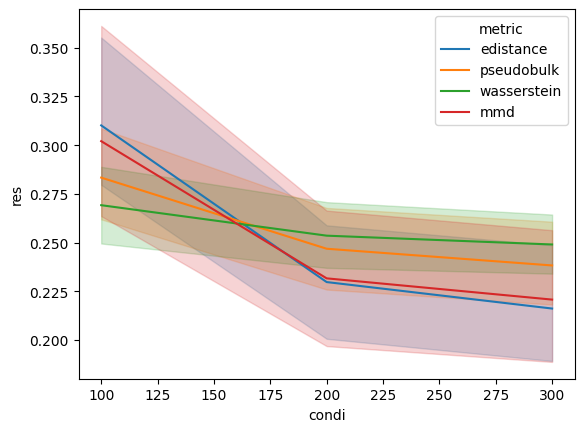

In [ ]:
import itertools
import seaborn as sns

def normalize_2d(matrix):
  """
  matrix: df colum we want to normalize
  output: the normalized column, sum all float entries equal 1
  """
  norm = np.linalg.norm(matrix)
  matrix = matrix/norm  # normalized matrix
  return matrix


metrics=list(["edistance",'pseudobulk','wasserstein','mmd'])
res2=[]
for m in metrics:
  new=df[df['metric']==m]
  res2.append(list(normalize_2d(new['res'])))


flat_res = [item for sublist in res2 for item in sublist]
df.loc[:,['res']]=flat_res

sns.lineplot(data=df, x="condi", y="res", hue="metric")